In [1]:
import modules.ensemble_model as ensemble
from pathlib import Path
import numpy as np
from modules.mapper import FileMapper as fm
from modules.dataset import Dataset
from modules.ensemble_dataset import EnsembleDataset
from modules.ensemble_dataset_image_only import Dataset as dataset_2
from torch.utils.data import DataLoader
import torchtuples as tt
from pycox.models import LogisticHazard
import pickle
import random
from modules.utils import getPatientIdentifier, collate_fn, returnMontage, get_optimizer
import sys
import torch
%load_ext autoreload
%autoreload 2
from torchtuples.base import Model
from typing import Dict

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
import pandas as pd
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [3]:
import os
import time
from collections import OrderedDict, defaultdict
import warnings
import contextlib
import torchtuples.callbacks as cb
from torchtuples.optim import AdamW, OptimWrap
from torchtuples.tupletree import tuplefy, TupleTree, make_dataloader
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.models.loss import nll_logistic_hazard
from torchtuples.utils import make_name_hash, array_or_tensor, is_data, is_dl
from torch import Tensor
from pycox import models
from pycox.models.utils import pad_col, make_subgrid
from pycox.preprocessing import label_transforms
from pycox.models.interpolation import InterpolateLogisticHazard

# Create MRI Dataset

In [4]:
preop_patients = []
for path in Path('./data/preoperative_zscore').glob('BMIAXNA*'):
    preop_patients.append(path)

In [5]:
id_mapping = './data/pickles_jsons/id_surv_mapping_10_groups.json'

In [6]:
mapper_class = fm(preop_patients, id_mapping, normalized=True)
dataset = mapper_class.generate_mapping()

Number of patients/folders: 1016


In [7]:
with open('./data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)
dataset_filtered = [entry for entry in dataset if entry['ENT'] is not None]
dataset_filtered = [entry for entry in dataset_filtered if entry['id'] not in filter_ids]

## Set Random seed and randomize dataset

In [8]:
random.seed(4)
random.shuffle(dataset_filtered)

# Clinical Part

# Logistic Hazard Model

In [9]:
final_df = pd.read_csv('./clinical_model/final_preoperative_dataset_ids.csv')

In [10]:
nn_dataset = final_df.loc[(final_df['KPSpre'].notnull()) 
                     & (final_df['ENTvolML'].notnull()) 
                     & (final_df['ENTside'].notnull())]

In [11]:
with open('./data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)

In [12]:
filter_ids

['BMIAXNAT_S10281', 'BMIAXNAT_S06575']

In [13]:
nn_dataset = nn_dataset.loc[~nn_dataset['ID'].isin(filter_ids), :]

In [14]:
print("Total Patients: {}".format(len(nn_dataset)))

Total Patients: 1016


In [16]:
nn_dataset.loc[:, 'ENTside'] = nn_dataset['ENTside'].apply(lambda x: 1 if x == 'R' else 0)
nn_dataset.loc[:, 'DeathObserved'] = nn_dataset['DeathObserved'].apply(lambda x: 1 if x is True else 0)
nn_dataset.loc[:, 'Chemo'] = nn_dataset['Chemo'].apply(lambda x: 1 if x is True else 0)
nn_dataset.loc[:, 'GenderV2'] = nn_dataset['GenderV2'].apply(lambda x: 1 if x == 'Female' else 0)

In [17]:
with open('./data/pickles_jsons/ids_per_phase.pkl', 'rb') as file:
    phase_id_dict = pickle.load(file)

In [ ]:
df_train = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['train'])]
sorterIndex_train = dict(zip(phase_id_dict['train'], range(len(phase_id_dict['train']))))
df_train['rank'] = df_train['ID'].map(sorterIndex_train)
df_train.sort_values(['rank'], ascending = [True], inplace = True)
df_train.drop('rank', 1, inplace = True)

df_test = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['test'])]
sorterIndex_test = dict(zip(phase_id_dict['test'], range(len(phase_id_dict['test']))))
df_test['rank'] = df_test['ID'].map(sorterIndex_test)
df_test.sort_values(['rank'], ascending = [True], inplace = True)
df_test.drop('rank', 1, inplace = True)

df_val = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['val'])]
sorterIndex_val = dict(zip(phase_id_dict['val'], range(len(phase_id_dict['val']))))
df_val['rank'] = df_val['ID'].map(sorterIndex_val)
df_val.sort_values(['rank'], ascending = [True], inplace = True)
df_val.drop('rank', 1, inplace = True)

In [ ]:
df_train.head(1)

In [ ]:
df_val.head(1)

## Preprocessing

In [21]:
cols_standardize = ['age', 'ENTvolML', 'KPSpre']
cols_leave = ['ENTside', 'GenderV2', 'Chemo', 'SurgeryExtend']
# cols_leave = ['ENTside', 'Chemo', 'SurgeryExtend']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

### Train/test/val split

In [22]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.fit_transform(df_test).astype('float32')
x_val = x_mapper.fit_transform(df_val).astype('float32')

In [23]:
clinical_dataset = np.concatenate((x_train, x_test, x_val), axis=0)

# Datasets

In [24]:
train_dataset = EnsembleDataset(dataset_filtered, clinical=clinical_dataset, phase='train', normalize=False, size=64)
val_dataset = EnsembleDataset(dataset_filtered, clinical=clinical_dataset, phase='val', normalize=False, size=64)
test_dataset = dataset_2(dataset_filtered, clinical=clinical_dataset, phase='test', normalize=False, size=64)

Training Size: 711
Validation Size: 101
Test Size: 204


# DataLoaders

In [25]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          num_workers=6,
                          shuffle=False,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        num_workers=6, 
                        shuffle=False,
                        collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=204,
                         shuffle=False)

In [26]:
# batch = next(iter(train_loader))

In [27]:
class AlteredModel(Model):
    @property
    def optimizer(self):
        return self._optimizer

    @optimizer.setter
    def optimizer(self, optimizer):
        self._optimizer = optimizer
        if callable(self._optimizer):
            self._optimizer = self._optimizer(params=self.net.parameters())
        if not isinstance(self._optimizer, OptimWrap):
            self._optimizer = OptimWrap(self._optimizer)
        
    def compute_metrics(self, data, metrics=None) -> Dict[str, torch.Tensor]:
        """Function for computing the loss and other metrics.
        
        Arguments:
            data {tensor or tuple} -- A batch of data. Typically the tuple `(input, target)`.
        Keyword Arguments:
            metrics {dict} -- A dictionary with metrics. If `None` use `self.metrics`. (default: {None})
        """
        return_metrics = {}
        if metrics is None:
            metrics = self.metrics
        if (self.loss is None) and (self.loss in metrics.values()):
            raise RuntimeError(f"Need to set `self.loss`.")
        
        input, target = data
        input = self._to_device(input)
        target = self._to_device(target)
#         out1, out2 = self.net(input)
        combined = self.net(input)
#         print(combined.shape)
        combined = tuplefy(combined)
#         out1 = tuplefy(out1)
#         out2 = tuplefy(out2)
        
#         resnet_loss = self.loss(*out1, *target)
#         clinical_loss = self.loss(*out2, *target)
        loss = self.loss(*combined, *target)
#         loss = resnet_loss + clinical_loss

        return {'loss': loss}
#         return {'loss': loss, 
#                 'loss_resnet': resnet_loss, 
#                 "loss_clinical": clinical_loss}
    
    def _setup_metrics(self, metrics=None):
        all_metrics = {'loss': self.loss}
        if metrics is not None:
            if not hasattr(metrics, 'items'):
                if not hasattr(metrics, '__iter__'):
                    metrics = [metrics]
                metrics = {met.__name__: met for met in metrics}
            if 'loss' in metrics:
                raise ValueError("The 'loss' keyword is reserved for the loss function.")
            all_metrics.update(metrics)
        return all_metrics
    
    def fit_dataloader(self, dataloader, epochs=1, callbacks=None, verbose=True, metrics=None,
                       val_dataloader=None):
        """Fit a dataloader object.
        See 'fit' for tensors and np.arrays.
        
        Arguments:
            dataloader {dataloader} -- A dataloader that gives (input, target).
        
        Keyword Arguments:
            epochs {int} -- Number of epochs (default: {1})
            callbacks {list} -- list of callbacks (default: {None})
            verbose {bool} -- Print progress (default: {True})
        
        Returns:
            TrainingLogger -- Training log
        """
        self._setup_train_info(dataloader)
        self.metrics = self._setup_metrics(metrics)
        self.log.verbose = verbose
        self.val_metrics.dataloader = val_dataloader
        if callbacks is None:
            callbacks = []
        self.callbacks = cb.TrainingCallbackHandler(self.optimizer, self.train_metrics, self.log,
                                                    self.val_metrics, callbacks)
        self.callbacks.give_model(self)

        stop = self.callbacks.on_fit_start()
        for _ in range(epochs):
            if stop: break
            stop = self.callbacks.on_epoch_start()
            if stop: break
            for data in dataloader:
                stop = self.callbacks.on_batch_start()
                if stop: break
                self.optimizer.zero_grad()
                self.batch_metrics = self.compute_metrics(data, self.metrics)
                self.batch_loss = self.batch_metrics['loss']
                self.batch_loss.backward()
                stop = self.callbacks.before_step()
                if stop: break
                self.optimizer.step()
                stop = self.callbacks.on_batch_end()
                if stop: break
            else:
                stop = self.callbacks.on_epoch_end()
        self.callbacks.on_fit_end()
        return self.log

In [28]:
class Base(AlteredModel):
    """Base class for survival models. 
    Essentially same as torchtuples.Model, 
    """
    def predict_surv(self, input, batch_size=8224, numpy=None, eval_=True,
                     to_cpu=False, num_workers=0):
        raise NotImplementedError

    def predict_surv_df(self, input, batch_size=8224, eval_=True, num_workers=0):
        raise NotImplementedError

    def predict_hazard(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                       num_workers=0):
        raise NotImplementedError

    def predict_pmf(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                    num_workers=0):
        raise NotImplementedError

In [29]:
class LogisticAltered(Base):
    label_transform = label_transforms.LabTransDiscreteTime

    def __init__(self, net, optimizer=None, device=None, duration_index=None, loss=None):
        self.duration_index = duration_index
        if loss is None:
            loss = models.loss.NLLLogistiHazardLoss()
        super().__init__(net, loss, optimizer, device)

    @property
    def duration_index(self):
        """
        Array of durations that defines the discrete times. This is used to set the index
        of the DataFrame in `predict_surv_df`.
        
        Returns:
            np.array -- Duration index.
        """
        return self._duration_index

    @duration_index.setter
    def duration_index(self, val):
        self._duration_index = val

    def predict_surv_df(self, input, batch_size=8224, eval_=True, num_workers=0):
        surv = self.predict_surv(input, batch_size, True, eval_, True, num_workers)
        return pd.DataFrame(surv.transpose(), self.duration_index)

    def predict_surv(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                     num_workers=0, epsilon=1e-7):
        hazard = self.predict_hazard(input, batch_size, False, eval_, to_cpu, num_workers)
        surv = (1 - hazard).add(epsilon).log().cumsum(1).exp()
        return tt.utils.array_or_tensor(surv, numpy, input)


    def predict_hazard(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                       num_workers=0):
        hazard = self.predict(input, batch_size, False, eval_, False, to_cpu, num_workers).sigmoid()
        return tt.utils.array_or_tensor(hazard, numpy, input)

    def interpolate(self, sub=10, scheme='const_pdf', duration_index=None):
        if duration_index is None:
            duration_index = self.duration_index
        return InterpolateLogisticHazard(self, scheme, duration_index, sub)

# ResNet-10

In [30]:
cuts = np.array([0., 70., 134., 213., 290., 365., 450., 623., 829., 1785.])

In [31]:
net = ensemble.generate_model(model_depth=10,
                        n_classes=10,
                        n_input_channels=4,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=False,
                        widen_factor=1.0,
                             dropout=0.5)

In [32]:
net

ResNet(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=T

# Model

In [33]:
# model = LogisticAltered(net, 
#                         tt.optim.AdamWR(params=[{'params': net.seq.parameters(), 'lr': 0.009}], lr=0.001), 
#                         duration_index=cuts, 
#                         device=0)

In [34]:
model = LogisticAltered(net, 
                        tt.optim.AdamW(), 
                        duration_index=cuts, 
                        device=0)

In [35]:
with open('y_train_example2.pk', 'rb') as file:
    x = pickle.load(file)
    
with open('y_train_example.pk', 'rb') as file:
    y = pickle.load(file)

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



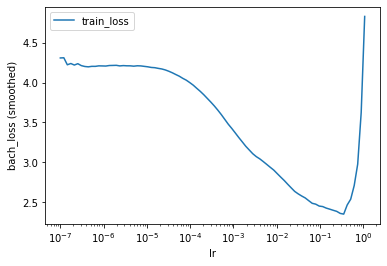

In [42]:
batch_size = 128
lrfind = model.lr_finder(x, y, batch_size, tolerance=50)
_ = lrfind.plot()

In [43]:
lrfind.get_best_lr()

0.035111917342151515

In [34]:
# model.compute_metrics(batch)

In [35]:
num_epochs = 100

In [ ]:
log = model.fit_dataloader(train_loader, num_epochs, [tt.cb.EarlyStopping(patience=5)], True, val_dataloader=val_loader)

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



0:	:10s / 4m:10s],		train_loss: 3.0039,	val_loss: 3.0755


In [37]:
log.to_pandas()

,train_loss,val_loss
0,3.397250,3.419361
1,2.437016,5.159957
2,2.274206,2.437434
3,2.232174,2.518845
4,2.173498,2.414410
5,2.161051,2.182460
6,2.138545,2.101861
7,2.148491,2.141276
8,2.141690,2.174952
9,2.149343,2.259165
